# Regimes Plot

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean as cm
import numpy as np
import cf_xarray as cfxr

In [3]:
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho'].sel(yh=slice(None,-50))

In [4]:
xh = deptho['xh']
yh = deptho['yh']

In [36]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [38]:
land_mask = (0 * deptho).fillna(1)
land = xr.where(np.isnan(deptho.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(deptho, 'mom6_01')

In [56]:
import matplotlib.patheffects as path_effects


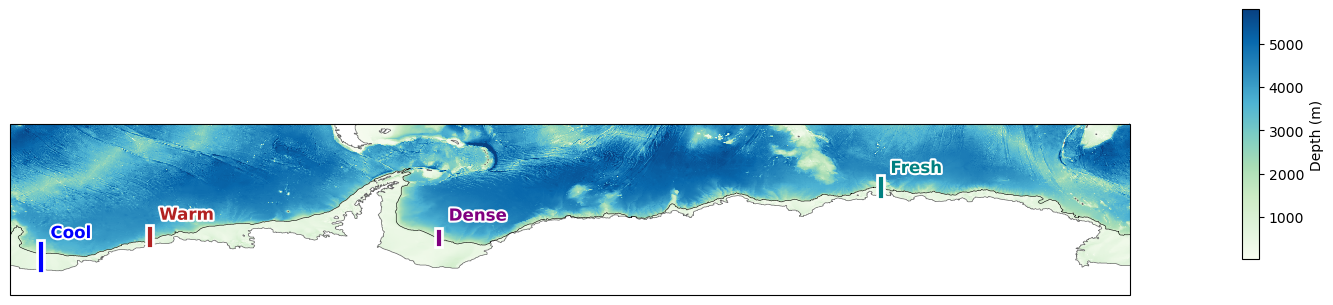

In [58]:
fig = plt.figure(figsize=(14, 10))

# Main map axis — shrink width to ~85% so colorbar fits nicely to the right
ax = fig.add_axes([0.05, 0.1, 0.8, 0.8], projection=ccrs.Miller())  # [left, bottom, width, height]

ax.set_extent([-280, -30, -82, -50], crs=ccrs.PlateCarree())

mappable = deptho.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='GnBu',
    add_colorbar=False  # Disable automatic colorbar
)

cbar_ax = fig.add_axes([0.93, 0.45, 0.012, 0.25])  # narrower and shorter, a bit higher on figure

# Create colorbar for the mappable
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label('Depth (m)')

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels=[0, 1], colors='dimgrey', linewidths=0.5, transform=ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels=[0, 1], colors='k', linewidths=0.4, transform=ccrs.PlateCarree())

lines = [
    (-170, (-78.5, -74.5), "Cool", 'blue'),
    (-260, (-66, -62.5), "Fresh", 'teal'),
    (-135, (-74.7, -72), "Warm", 'firebrick'),
    (-42,  (-74.5, -72.5), "Dense", 'purple')
]

for lon, (lat_start, lat_end), label, color in lines:
    lon_plot = ((lon + 180) % 360) - 180
    
    # Plot white "outline" line thicker underneath
    ax.plot([lon_plot, lon_plot], [lat_start, lat_end],
            color='white', linewidth=7, transform=ccrs.PlateCarree(), zorder=2)
    # Plot colored line on top
    ax.plot([lon_plot, lon_plot], [lat_start, lat_end],
            color=color, linewidth=3, transform=ccrs.PlateCarree(), zorder=3)
    
    mid_lat = (lat_start + lat_end) / 2
    
    txt = ax.text(lon_plot + 3, mid_lat + 3, label, color=color,
                  fontsize=12, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)
    
    # Add white outline stroke to text
    txt.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='white'),
        path_effects.Normal()
    ])

# Add axis labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()
